In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

# Load and Check Data

In [37]:
data = pd.read_csv("loan_data_1.csv")

In [38]:
data.drop(["Unnamed: 0", "Loan_ID"], axis=1, inplace=True)

In [39]:
data.shape

(381, 12)

# Dealing With Missing Values

In [40]:
categoricals_nulls = ["Gender", "Dependents", "Education", "Credit_History", "Self_Employed"]
for i in categoricals_nulls:
    vals = data[i].mode().values[0]
    data[i].fillna(vals, inplace=True)

In [41]:
numericals_nulls = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
for i in numericals_nulls:
    vals = data[i].median()
    data[i].fillna(vals, inplace=True)

In [42]:
categoricals = ["Gender", "Married", "Dependents", "Education", "Self_Employed",
               "Credit_History", "Property_Area", "Loan_Status"]

numericals = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]

# Encoding Values

In [43]:
le = LabelEncoder()
for i in categoricals:
    data[i] = le.fit_transform(data[i])

# Target Variable Status

* Dataset is imbalanced.

# Dealing with Imbalancing 

In [44]:
y = data.Loan_Status
X = data.drop("Loan_Status" , axis = 1)

In [45]:
# sampling_strategy için 'minority','not majority' ve 'all' fonksiyonları benzer sonuçları verdi.  
smote = SMOTE(sampling_strategy="all")

X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

0    271
1    271
Name: Loan_Status, dtype: int64

In [46]:
# Merge the balanced datas
data = pd.concat([X_sm,y_sm], axis = 1)

* We balanced the dataset.

# Building Model

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

In [48]:
y = data.Loan_Status
X = data.drop("Loan_Status" , axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Random Forest Model

In [49]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

acc_rf = round(accuracy_score(y_test, y_pred),3)
recall_rf = round(recall_score(y_test, y_pred, average='weighted'),3)
prec_rf = round(precision_score(y_test, y_pred, average='weighted'),3)
f1_rf = round(f1_score(y_test, y_pred, average='weighted'),3)

print("Accuracy Score:", acc_rf)
print("Recall Score:", recall_rf)
print(f"Precision Score: {prec_rf}")
print("F-1 Score:", f1_rf)

Accuracy Score: 0.853
Recall Score: 0.853
Precision Score: 0.866
F-1 Score: 0.852



# Explain Prediction by SHAP

In [50]:
import shap 
shap.initjs()

In [51]:
explainer = shap.TreeExplainer(model_rf)

## An Individual Shapley Values

In [52]:
i = 25
observation = X_train.iloc[i]
expected = model_rf.predict([observation])[0]

In [53]:
# Shap values for individual
print(observation)
print("Expected: ", expected)

Gender                  1.0
Married                 1.0
Dependents              1.0
Education               0.0
Self_Employed           0.0
ApplicantIncome      2750.0
CoapplicantIncome    1842.0
LoanAmount            115.0
Loan_Amount_Term      360.0
Credit_History          1.0
Property_Area           1.0
Name: 172, dtype: float64
Expected:  1


In [54]:

#An Individuals Shapley Values
shap_values = explainer.shap_values(observation)
print(f"{shap_values[expected]}")

[-0.00053329  0.04381781  0.00163927 -0.00280844  0.00196915  0.03692074
  0.04612108  0.00260632  0.03105985  0.25189333  0.04576684]


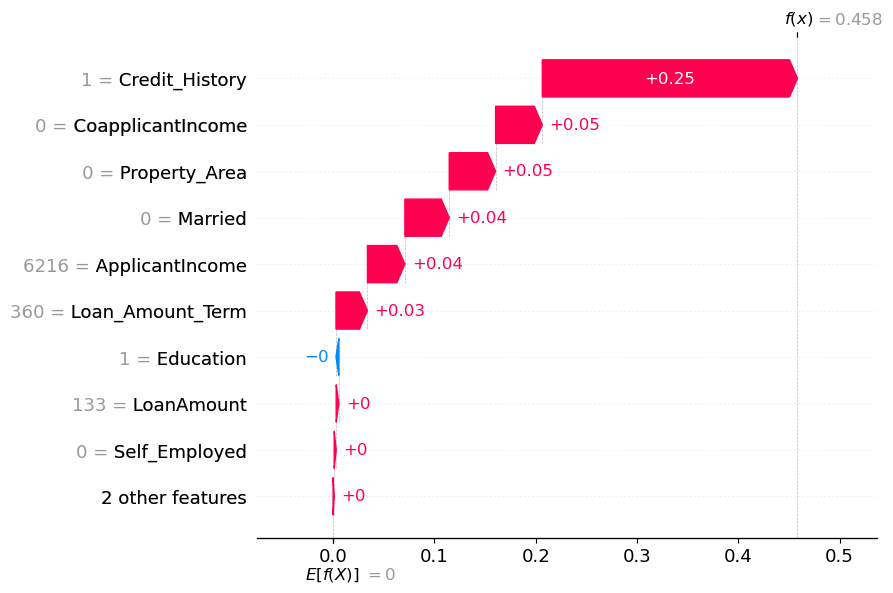

In [55]:
#waterfallplot
base_value = 0
shap_values_matrix = shap.Explanation(values=shap_values, base_values=base_value, data=X_train)
shap.plots.waterfall(shap_values_matrix[expected])

## Whole Dataset Shapley Values

In [56]:
all_shap_values = explainer.shap_values(X_train)

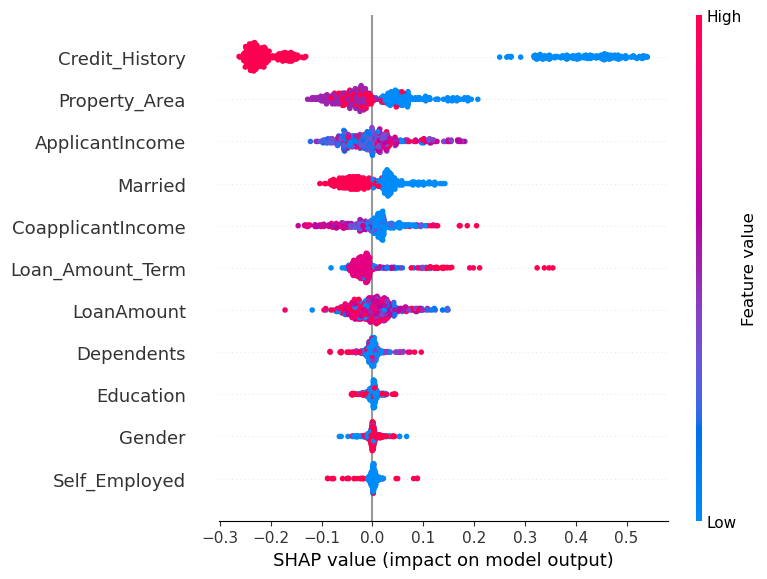

In [57]:
#Summary_plot
shap.summary_plot(all_shap_values[0], features=X_train)